# Fourth lecture: Julia

## Supervised Machine Learning: Decision Tree and Random Forest

## In this notebook:
* [1. Import packages](#first-bullet)
* [2. Functions definition](#second-bullet)
* [3. Data preparation](#third-bullet)
    * [3.a Import data from CSV](#third-a-bullet)
    * [3.b Preprocess the data](#third-b-bullet)
    * [3.c Making some preliminary analysis](#third-c-bullet)
    * [3.d Define train and test dataset](#third-d-bullet)
* [4. Decision Tree](#forth-bullet)
    * [4.a Train the model](#forth-a-bullet)
    * [4.b Make predictions](#forth-b-bullet)
    * [4.c Compute metrics](#forth-c-bullet)
* [5. Random Forest](#fifth-bullet)
    * [5.a Train the model](#fifth-a-bullet)
    * [5.b Test the model](#fifth-b-bullet)
    * [5.c Compute metrics](#fifth-c-bullet)
* [6. Result evalutation](#sixth-bullet)
* [7. References](#seventh-bullet)

## 1. Import packages <a class="anchor" id="first-bullet"></a>

In [1]:
using DataFrames
using DecisionTree
using Random
using MLJ
using ROCAnalysis
using Distributed
using CSV
using Plots
using Statistics
using StatsPlots
using PlotlyJS
using ROC

WebIO._IJuliaInit()

## 2. Functions definition <a class="anchor" id="second-bullet"></a>

In [2]:
function calculate_metrics(conf_matrix)
    
    #=
    Compute precision, recall and accuracy metrics.
    
    Input: 
        conf_matrix: confusion matrix; Matrix{Int}
    Output:
        val_precision: precision; Float
        val_recall: recall; Float
        val_accuracy: accuracy; Float
    
    =#
    
    TN, FP, FN, TP = conf_matrix
    
    val_precision = TP / (TP + FP)
    val_recall = TP / (TP + FN)
    val_accuracy = (TP + TN) / (TP + TN + FP + FN)
    
    return val_precision, val_recall, val_accuracy
end

function show_confmatrix(conf_matrix)
    
    #=
    Plot the confusion matrix with a colorcoding and reporting the number of observation in each cell
    
    Input: 
        conf_matrix: confusion matrix; Matrix{Int}
    
    =#  
    
    StatsPlots.heatmap(
    conf_matrix,
    c=:coolwarm,
    xlabel="Predicted",
    ylabel="Ground Truth",
    title="Confusion Matrix",
    cbar=true,
    axis=true,
    size=(400, 400),
    )
    annotate!((1, 1, text(string(conf_matrix[1, 1]), :white, :center)))
    annotate!((1, 2, text(string(conf_matrix[1, 2]), :white, :center)))
    annotate!((2, 1, text(string(conf_matrix[2, 1]), :white, :center)))
    annotate!((2, 2, text(string(conf_matrix[2, 2]), :white, :center)))

    xticks!([1, 2], ["False", "True"])
    yticks!([1, 2], ["False", "True"])
end;

## 3. Data preparation <a class="anchor" id="third-bullet"></a>

### 3.a Import data from CSV <a class="anchor" id="third-a-bullet"></a>

In [3]:
Random.seed!(124)

cd("./Data/")
data = CSV.File("Titanic_data.csv") |> DataFrame
cd("..")
first(data,10)

Row,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
,Int64,Int64,Int64,String,String7,Float64?,Int64,Int64,String31,Float64,String15?,String1?
1,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.25,missing,S
2,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,71.2833,C85,C
3,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.925,missing,S
4,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1,C123,S
5,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.05,missing,S
6,6,0,3,"Moran, Mr. James",male,missing,0,0,330877,8.4583,missing,Q
7,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
8,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.075,missing,S
9,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,missing,S


### 3.b Preprocess the data <a class="anchor" id="third-b-bullet"></a>

In [4]:
select!(data, Not(:Name, :Ticket, :Cabin))
data[!, "Embarked"] .= coalesce.(data[!, "Embarked"], missing)
data[!, "Age"] .= coalesce.(data[!, "Age"], 0)
dropmissing!(data, disallowmissing=true)

first(data, 5)

Row,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
,Int64,Int64,Int64,String7,Real,Int64,Int64,Float64,String1
1,1,0,3,male,22.0,1,0,7.25,S
2,2,1,1,female,38.0,1,0,71.2833,C
3,3,1,3,female,26.0,0,0,7.925,S
4,4,1,1,female,35.0,1,0,53.1,S
5,5,0,3,male,35.0,0,0,8.05,S


## 3.c Making some preliminary analysis <a class="anchor" id="third-c-bullet"></a>

In [5]:
PlotlyJS.plot(data, x=:Survived, y=:Age, kind="box")

data: [
  "box with fields type, x, xaxis, y, and yaxis"
]

layout: "layout with fields legend, margin, template, xaxis, and yaxis"

In [6]:
PlotlyJS.plot(data, x=:Survived, y=:Fare, kind="box")

data: [
  "box with fields type, x, xaxis, y, and yaxis"
]

layout: "layout with fields legend, margin, template, xaxis, and yaxis"

In [7]:
println(">"^10," Fare, survived ","<"^10)
describe(data[!,:Fare][data[!, :Survived].==1])
println(" ")
println(">"^10," Fare, dead ","<"^10)
describe(data[!,:Fare][data[!, :Survived].==0])

>>>>>>>>>> Fare, survived <<<<<<<<<<
Summary Stats:
Length:         340
Missing Count:  0
Mean:           48.209498
Minimum:        0.000000
1st Quartile:   12.443750
Median:         26.000000
3rd Quartile:   56.946900
Maximum:        512.329200
Type:           Float64
 
>>>>>>>>>> Fare, dead <<<<<<<<<<
Summary Stats:
Length:         549
Missing Count:  0
Mean:           22.117887
Minimum:        0.000000
1st Quartile:   7.854200
Median:         10.500000
3rd Quartile:   26.000000
Maximum:        263.000000
Type:           Float64


### 3.d Define train and test dataset <a class="anchor" id="third-d-bullet"></a>

In [8]:
trainSet, testSet = partition(eachindex(Array(data.PassengerId)), 0.8, shuffle=true)

trainSet = data[trainSet, :]
testSet = data[testSet, :]

X_train = Array(DataFrames.select(trainSet, Not(:Survived,:Sex)))
y_train = trainSet.Survived
X_test = Array(DataFrames.select(testSet, Not(:Survived, :Sex)))
y_test = testSet.Survived

println("Train set lenght: ",nrow(trainSet))
println("Train set lenght: ",nrow(testSet))

Train set lenght: 711
Train set lenght: 178


## 4. Decision Tree <a class="anchor" id="forth-bullet"></a>

### 4.a Train the model <a class="anchor" id="forth-a-bullet"></a>

In [9]:
dt = DecisionTreeClassifier()
DecisionTree.fit!(dt, X_train, y_train)

DecisionTreeClassifier
max_depth:                -1
min_samples_leaf:         1
min_samples_split:        2
min_purity_increase:      0.0
pruning_purity_threshold: 1.0
n_subfeatures:            0
classes:                  [0, 1]
root:                     Decision Tree
Leaves: 193
Depth:  19

### 4.b Make predictions <a class="anchor" id="forth-b-bullet"></a>

In [10]:
dt_pred = DecisionTree.predict(dt, X_test);

### 4.c Compute metrics <a class="anchor" id="forth-c-bullet"></a>

#### Confusion matrix

          ┌─────────────┐
          │Ground Truth │
┌─────────┼──────┬──────┤
│Predicted│  0   │  1   │
├─────────┼──────┼──────┤
│    0    │  87  │  30  │
├─────────┼──────┼──────┤
│    1    │  29  │  32  │
└─────────┴──────┴──────┘


┌ Warning: Levels not explicitly ordered. Using the order [0, 1]. The "positive" level is 1. 
└ @ StatisticalMeasures.ConfusionMatrices ~/.julia/packages/StatisticalMeasures/Wnt7C/src/confusion_matrices.jl:333


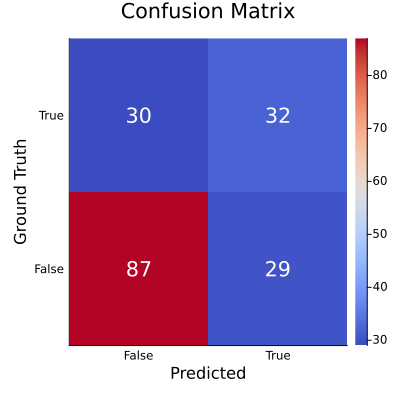

In [11]:
dt_cm = MLJ.confusion_matrix(dt_pred,y_test)
display(dt_cm)
dt_matrix = ConfusionMatrices.matrix(dt_cm)
show_confmatrix(dt_matrix)

#### Standard metrics

In [12]:
dt_prec, dt_rec, dt_acc = calculate_metrics(dt_matrix)

println(">"^10," Decision Tree Model ","<"^10)
println("Precision: ", dt_prec)
println("Recall: ", dt_rec)
println("Accuracy: ", dt_acc)

>>>>>>>>>> Decision Tree Model <<<<<<<<<<
Precision: 0.5245901639344263
Recall: 0.5161290322580645
Accuracy: 0.6685393258426966


## 5. Random Forest <a class="anchor" id="fifth-bullet"></a>

### 5.a Train the model <a class="anchor" id="fifth-a-bullet"></a>

In [13]:
@load RandomForestClassifier pkg="DecisionTree"

rf_model = RandomForestClassifier(n_trees=500)
DecisionTree.fit!(rf_model, X_train, y_train)

[ Info: For silent loading, specify `verbosity=0`. 


import MLJDecisionTreeInterface ✔


RandomForestClassifier
n_trees:             500
n_subfeatures:       -1
partial_sampling:    0.7
max_depth:           -1
min_samples_leaf:    1
min_samples_split:   2
min_purity_increase: 0.0
classes:             [0, 1]
ensemble:            Ensemble of Decision Trees
Trees:      500
Avg Leaves: 126.856
Avg Depth:  18.484

### 5.b Make predictions <a class="anchor" id="fifth-b-bullet"></a>

In [14]:
rf_pred = DecisionTree.predict(rf_model, X_test);

### 5.c Compute metrics <a class="anchor" id="fifth-c-bullet"></a>

#### Confusion matrix

          ┌─────────────┐
          │Ground Truth │
┌─────────┼──────┬──────┤
│Predicted│  0   │  1   │
├─────────┼──────┼──────┤
│    0    │ 100  │  27  │
├─────────┼──────┼──────┤
│    1    │  16  │  35  │
└─────────┴──────┴──────┘


┌ Warning: Levels not explicitly ordered. Using the order [0, 1]. The "positive" level is 1. 
└ @ StatisticalMeasures.ConfusionMatrices ~/.julia/packages/StatisticalMeasures/Wnt7C/src/confusion_matrices.jl:333


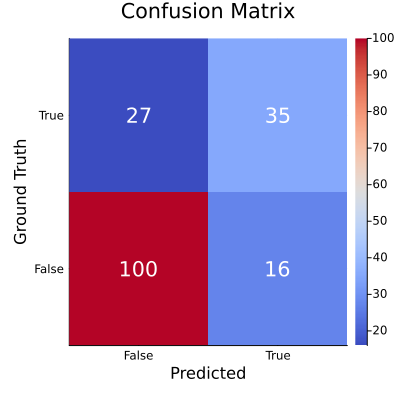

In [15]:
rf_cm = MLJ.confusion_matrix(rf_pred,y_test)
display(rf_cm)
rf_matrix = ConfusionMatrices.matrix(rf_cm)
show_confmatrix(rf_matrix)

#### Standard metrics

In [16]:
rf_prec, rf_rec, rf_acc = calculate_metrics(rf_matrix)

println(">"^10," Random Forest Model ","<"^10)
println("Precision: ", rf_prec)
println("Recall: ", rf_rec)
println("Accuracy: ", rf_acc)

>>>>>>>>>> Random Forest Model <<<<<<<<<<
Precision: 0.6862745098039216
Recall: 0.5645161290322581
Accuracy: 0.7584269662921348


## 6. Result evalutation <a class="anchor" id="sixth-bullet"></a>

#### Receiver Operating Characteristic (ROC) analysis

In [17]:
bool_test = Bool.(y_test)

dt_roc = ROC.roc(dt_pred, bool_test, true)
rf_roc = ROC.roc(rf_pred, bool_test, true);

In [18]:
dt_auc = ROC.AUC(dt_roc)
println("Area Under the Curve (AUC) - DecisionTree: ",dt_auc)
rf_auc = ROC.AUC(rf_roc)
println("Area Under the Curve (AUC) - RandomForest: ",rf_auc)

Area Under the Curve (AUC) - DecisionTree: 0.6330645161290323
Area Under the Curve (AUC) - RandomForest: 0.7132925472747498


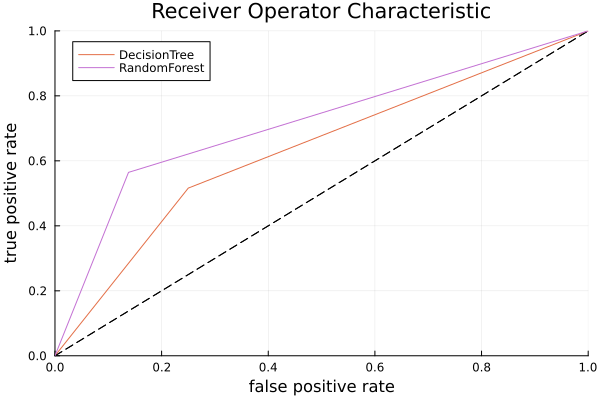

In [19]:
Plots.plot(dt_roc, label="DecisionTree")
Plots.plot!(rf_roc, label="RandomForest")

## 7. References <a class="anchor" id="seventh-bullet"></a>

1. **An Introduction to Statistical Learning** – *Gareth James , Daniela Witten , Trevor Hastie , Robert Tibshirani and Jonathan Taylor*
2. **The Elements of Statistical Learning** – *T.Hastie, R. Tibshirani and J.H. Friedman*
3. **Analisi dei dati e Data Mining** – *A. Azzalini e B. Scarpa*